# [AI502] Programming Assignment 2
_student id: 20233359, name: Junyeob Baek_

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Synthetic time series example
Suppose a simple regression problem.

$$f(t) = \sin(0.01t) + 0.2 \epsilon, \quad \epsilon\sim\mathcal{N}(0,1), \quad t\in [0,1000]$$

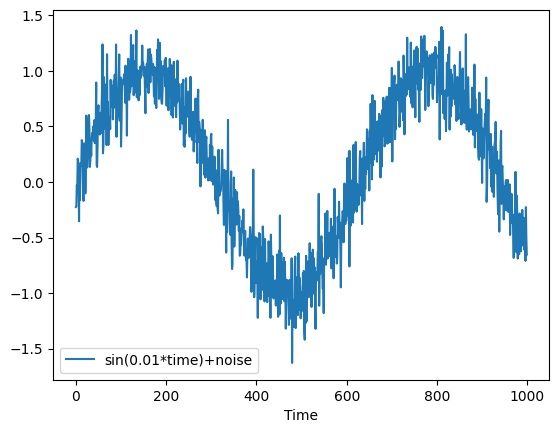

In [96]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

# Build My Own RNN

In [97]:
class MyRNN(nn.Module):
    def __init__(self):
        super(MyRNN, self).__init__()
        
        self.rnn = nn.LSTM(1, 10, batch_first=True)
        self.relu = nn.ReLU()
        self.final = nn.Linear(10, 1)

    def forward(self, inputs):
        outputs, hidden = self.rnn(inputs)
        outputs = outputs[:, -1, :]
        outputs = self.final(self.relu(outputs))

        return outputs

In [98]:
# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 80 # [4, 50, 100, 200, 300]
features = torch.zeros((T-tau, tau, 1)) # RNN Model needs tau inputs: shape is (996, 4, 1)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)].reshape(-1, 1)

labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

In [99]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.95)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    losses = []
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            output = net(x)
            loss = criterion(output, y.reshape(-1, 1))
            loss.backward()
            optim.step()
            running_loss += loss.item()
        scheduler.step()
        
        print("epoch: {}, loss: {:.2f}, lr:{:.5f}".format(epoch, running_loss, scheduler.get_lr()[-1]))
        losses.append(running_loss)
    plt.plot(np.arange(epochs), losses, label='Loss')
    plt.legend()
    plt.show()
    test_loss = criterion(net(test_data[:][0]), test_data[:][1])
    print('test loss: %f' % test_loss.mean().detach().numpy())
    
    
    return net

# Train My RNN

epoch: 1, loss: 8.29, lr:0.02000
epoch: 2, loss: 2.25, lr:0.02000
epoch: 3, loss: 2.11, lr:0.02000
epoch: 4, loss: 2.10, lr:0.02000
epoch: 5, loss: 2.18, lr:0.01805
epoch: 6, loss: 2.07, lr:0.01900
epoch: 7, loss: 2.08, lr:0.01900
epoch: 8, loss: 2.23, lr:0.01900
epoch: 9, loss: 2.12, lr:0.01900
epoch: 10, loss: 2.14, lr:0.01715
epoch: 11, loss: 1.97, lr:0.01805
epoch: 12, loss: 1.98, lr:0.01805
epoch: 13, loss: 2.00, lr:0.01805
epoch: 14, loss: 2.03, lr:0.01805
epoch: 15, loss: 2.04, lr:0.01629
epoch: 16, loss: 1.99, lr:0.01715
epoch: 17, loss: 1.96, lr:0.01715
epoch: 18, loss: 2.04, lr:0.01715
epoch: 19, loss: 1.99, lr:0.01715
epoch: 20, loss: 1.93, lr:0.01548
epoch: 21, loss: 1.95, lr:0.01629
epoch: 22, loss: 1.93, lr:0.01629
epoch: 23, loss: 1.97, lr:0.01629
epoch: 24, loss: 1.93, lr:0.01629
epoch: 25, loss: 1.92, lr:0.01470
epoch: 26, loss: 1.95, lr:0.01548
epoch: 27, loss: 2.07, lr:0.01548
epoch: 28, loss: 2.05, lr:0.01548
epoch: 29, loss: 1.97, lr:0.01548
epoch: 30, loss: 1.91, 

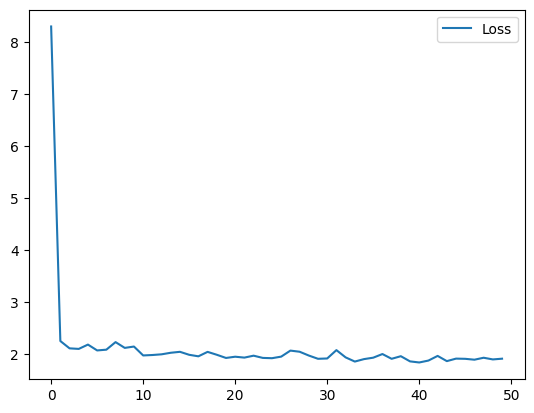

test loss: 0.446155


/home/junyeob/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [100]:
my_net = MyRNN()
my_net = train_net(my_net, train_data, criterion, 50, 0.02)

# Test My RNN(do not touch this part)

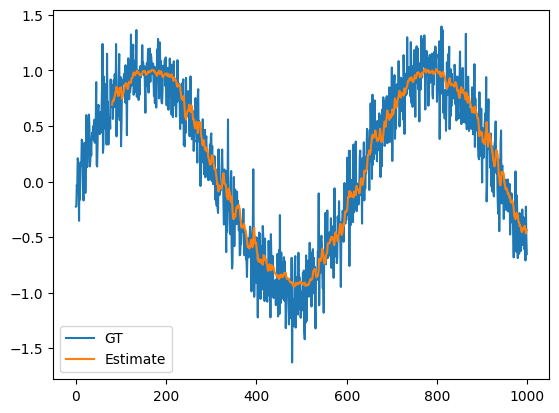

train loss: 0.04743688181042671
test loss: 0.049672726541757584


In [101]:
my_estimates = my_net(features)
plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), my_estimates.detach().numpy(), label='Estimate')
plt.legend()
plt.show()

my_train_estimate_loss = criterion(my_estimates[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
my_test_estimate_loss = criterion(my_estimates[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', my_train_estimate_loss)
print('test loss:', my_test_estimate_loss)

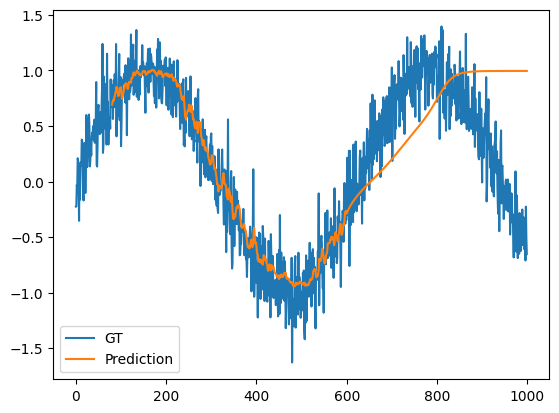

train loss: 0.04743688181042671
test loss: 0.446161687374115


In [102]:
my_predictions = torch.zeros_like(my_estimates)
my_predictions[:(train_number - tau)] = my_estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    my_predictions[i] = my_net(
        my_predictions[(i - tau):i].reshape(1, -1, 1)
    )

plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), my_predictions.detach().numpy(), label='Prediction')
plt.legend()
plt.show()

my_train_prediction_loss = criterion(my_predictions[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
my_test_prediction_loss = criterion(my_predictions[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', my_train_prediction_loss)
print('test loss:', my_test_prediction_loss)